In [1]:
from lerobot.envs.factory import make_env
from lerobot.configs.eval import EvalPipelineConfig


import abc
from dataclasses import dataclass, field
from typing import Any

import draccus

from lerobot.configs.types import FeatureType, PolicyFeature

from lerobot.utils.constants import (
    ACTION,
    LIBERO_KEY_EEF_MAT,
    LIBERO_KEY_EEF_POS,
    LIBERO_KEY_EEF_QUAT,
    LIBERO_KEY_GRIPPER_QPOS,
    LIBERO_KEY_GRIPPER_QVEL,
    LIBERO_KEY_JOINTS_POS,
    LIBERO_KEY_JOINTS_VEL,
    LIBERO_KEY_PIXELS_AGENTVIEW,
    LIBERO_KEY_PIXELS_EYE_IN_HAND,
    OBS_ENV_STATE,
    OBS_IMAGE,
    OBS_IMAGES,
    OBS_STATE,
)

import os
os.environ["MUJOCO_GL"] = "egl"
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import metaworld.policies as policies
import gym

%load_ext autoreload
%autoreload 2


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:
@dataclass
class EnvConfig(draccus.ChoiceRegistry, abc.ABC):
    task: str | None = None
    fps: int = 30
    features: dict[str, PolicyFeature] = field(default_factory=dict)
    features_map: dict[str, str] = field(default_factory=dict)
    max_parallel_tasks: int = 1
    disable_env_checker: bool = True

    @property
    def type(self) -> str:
        return self.get_choice_name(self.__class__)

    @property
    def package_name(self) -> str:
        """Package name to import if environment not found in gym registry"""
        return f"gym_{self.type}"

    @property
    def gym_id(self) -> str:
        """ID string used in gym.make() to instantiate the environment"""
        return f"{self.package_name}/{self.task}"

    @property
    @abc.abstractmethod
    def gym_kwargs(self) -> dict:
        raise NotImplementedError()


@EnvConfig.register_subclass("metaworld")
@dataclass
class MetaworldEnv(EnvConfig):
    task: str = "metaworld-push-v2"  # add all tasks
    fps: int = 80
    episode_length: int = 400
    obs_type: str = "pixels_agent_pos"
    render_mode: str = "segmentation"
    multitask_eval: bool = True
    features: dict[str, PolicyFeature] = field(
        default_factory=lambda: {
            "action": PolicyFeature(type=FeatureType.ACTION, shape=(4,)),
        }
    )
    features_map: dict[str, str] = field(
        default_factory=lambda: {
            "action": ACTION,
            "agent_pos": OBS_STATE,
            "top": f"{OBS_IMAGE}",
            "pixels/top": f"{OBS_IMAGE}",
        }
    )
    render_segmentation: bool = True

    def __post_init__(self):
        if self.obs_type == "pixels":
            self.features["top"] = PolicyFeature(type=FeatureType.VISUAL, shape=(480, 480, 3))

        elif self.obs_type == "pixels_agent_pos":
            self.features["agent_pos"] = PolicyFeature(type=FeatureType.STATE, shape=(4,))
            self.features["pixels/top"] = PolicyFeature(type=FeatureType.VISUAL, shape=(480, 480, 3))

        else:
            raise ValueError(f"Unsupported obs_type: {self.obs_type}")

    @property
    def gym_kwargs(self) -> dict:
        return {
            "obs_type": self.obs_type,
            "render_mode": self.render_mode,
            "render_segmentation": self.render_segmentation,
        }

In [269]:

import json
with open("/pfss/mlde/workspaces/mlde_wsp_IAS_SAMMerge/VLA/duc/lerobot/src/lerobot/envs/metaworld_config.json") as f:
    data = json.load(f)

all_50_tasks = ",".join(list(data['TASK_NAME_TO_ID'].keys())[:2])
mt_env = MetaworldEnv(
    task='assembly-v3',
    render_mode="rgb_array",
    render_segmentation=True
)
envs = make_env(mt_env, n_envs=1, use_async_envs=False)
envs

Creating Meta-World envs | task_groups=['assembly-v3'] | n_envs(per task)=1
Building vec env | group=assembly-v3 | task_id=0 | task=assembly-v3


{'assembly-v3': {0: SyncVectorEnv(num_envs=1)}}

In [2]:
from src.lerobot.envs.metaworld import *

In [7]:
testenv = MetaworldEnv(task='assembly-v3',
    render_mode="rgb_array",
    render_segmentation=True,
    obs_type="pixels_agent_pos")

In [8]:
obs, info = testenv.reset()

In [9]:
obs.keys()

dict_keys(['pixels', 'agent_pos', 'environment_state', 'segmentation'])

In [19]:
from scipy import ndimage as ndi
import numpy as np

def clean_and_smooth_mask(mask,
                          sigma=3.6,
                          thresh=0.45,
                          keep_largest=True):
    mask = mask.astype(np.float32)

    # 1. Smooth
    blurred = ndi.gaussian_filter(mask, sigma=sigma)
    binary = blurred > thresh

    # 2. Fill holes
    filled = ndi.binary_fill_holes(binary)

    # # 3. Keep largest component
    # if keep_largest:
    #     labeled, num = ndi.label(filled)
    #     if num > 1:
    #         sizes = ndi.sum(filled, labeled, range(1, num + 1))
    #         largest = np.argmax(sizes) + 1
    #         filled = (labeled == largest)

    return filled.astype(np.uint8)


In [256]:
len(TASK_POLICY_MAPPING)

50

In [22]:


EPISODES_PER_TASK = 1
MAX_STEPS = 200

TASK_POLICY_MAPPING = {
    "assembly-v3": "SawyerAssemblyV3Policy", "basketball-v3": "SawyerBasketballV3Policy",
    "bin-picking-v3": "SawyerBinPickingV3Policy", "box-close-v3": "SawyerBoxCloseV3Policy",
    "button-press-topdown-v3": "SawyerButtonPressTopdownV3Policy",
    "button-press-topdown-wall-v3": "SawyerButtonPressTopdownWallV3Policy",
    "button-press-v3": "SawyerButtonPressV3Policy", "button-press-wall-v3": "SawyerButtonPressWallV3Policy",
    "coffee-button-v3": "SawyerCoffeeButtonV3Policy", "coffee-pull-v3": "SawyerCoffeePullV3Policy",
    "coffee-push-v3": "SawyerCoffeePushV3Policy", "dial-turn-v3": "SawyerDialTurnV3Policy",
    "disassemble-v3": "SawyerDisassembleV3Policy", "door-close-v3": "SawyerDoorCloseV3Policy",
    "door-lock-v3": "SawyerDoorLockV3Policy", "door-open-v3": "SawyerDoorOpenV3Policy",
    "door-unlock-v3": "SawyerDoorUnlockV3Policy", "drawer-close-v3": "SawyerDrawerCloseV3Policy",
    "drawer-open-v3": "SawyerDrawerOpenV3Policy", "faucet-close-v3": "SawyerFaucetCloseV3Policy",
    "faucet-open-v3": "SawyerFaucetOpenV3Policy", "hammer-v3": "SawyerHammerV3Policy",
    "hand-insert-v3": "SawyerHandInsertV3Policy", "handle-press-side-v3": "SawyerHandlePressSideV3Policy",
    "handle-press-v3": "SawyerHandlePressV3Policy", "handle-pull-side-v3": "SawyerHandlePullSideV3Policy",
    "handle-pull-v3": "SawyerHandlePullV3Policy", "lever-pull-v3": "SawyerLeverPullV3Policy",
    "peg-insert-side-v3": "SawyerPegInsertionSideV3Policy", "peg-unplug-side-v3": "SawyerPegUnplugSideV3Policy",
    "pick-out-of-hole-v3": "SawyerPickOutOfHoleV3Policy", "pick-place-v3": "SawyerPickPlaceV3Policy",
    "pick-place-wall-v3": "SawyerPickPlaceWallV3Policy",
    "plate-slide-back-side-v3": "SawyerPlateSlideBackSideV3Policy",
    "plate-slide-back-v3": "SawyerPlateSlideBackV3Policy",
    "plate-slide-side-v3": "SawyerPlateSlideSideV3Policy", "plate-slide-v3": "SawyerPlateSlideV3Policy",
    "push-back-v3": "SawyerPushBackV3Policy", "push-v3": "SawyerPushV3Policy",
    "push-wall-v3": "SawyerPushWallV3Policy", "reach-v3": "SawyerReachV3Policy",
    "reach-wall-v3": "SawyerReachWallV3Policy", "shelf-place-v3": "SawyerShelfPlaceV3Policy",
    "soccer-v3": "SawyerSoccerV3Policy", "stick-pull-v3": "SawyerStickPullV3Policy",
    "stick-push-v3": "SawyerStickPushV3Policy", "sweep-into-v3": "SawyerSweepIntoV3Policy",
    "sweep-v3": "SawyerSweepV3Policy", "window-open-v3": "SawyerWindowOpenV3Policy",
    "window-close-v3": "SawyerWindowCloseV3Policy"}

def make_policy(task_name):
    policy_cls_name = TASK_POLICY_MAPPING[task_name]
    policy_cls = getattr(policies, policy_cls_name)
    return policy_cls()

task = 'disassemble-v3'
policy = make_policy(task)
# Pixel env (for dataset)

envs_pixel = MetaworldEnv(task=task,
    render_mode="rgb_array",
    render_segmentation=True,
    obs_type="pixels_agent_pos")


dataset = {}

# =========================
# 3. Collect loop
# =========================
print(f"\nCollecting data for task: {task}")

# Pixel vector env
vec_env_pixel = envs_pixel  # SyncVectorEnv(num_envs=1)

# State env (single env, NOT vector)

dataset[task] = []
episodes_collected = 0

while episodes_collected < EPISODES_PER_TASK:
    # ---- Reset BOTH envs with same seed ----
    seed = np.random.randint(0, 1_000_000)
    obs_pixel, info = vec_env_pixel.reset(seed=seed)
    
    print(obs_pixel.keys())
    print(obs_pixel['pixels'].shape)
    print(obs_pixel['agent_pos'].shape)
    episode_buffer = []
    done = False
    step = 0

    while not done and step < MAX_STEPS:
        # ---- ACTION from EXPERT (STATE env) ----
        state_obs = obs_pixel['environment_state']
        action = policy.get_action(state_obs)   # (act_dim,)

        # ---- Step BOTH envs ----
        next_pixel_obs, reward, terminated_p, truncated_p, info = vec_env_pixel.step(action)

        done = bool(terminated_p or truncated_p)

        ### Clean OOI mapping
        ooi_mapping = {k: v for k, v in info["ooi_mapping"].items() if isinstance(k, int)}
        ooi_mapping[99] = np.array(['wall'])
        print(ooi_mapping)

        ### Delete -1 value in original segmentation
        original_seg = obs_pixel["segmentation"]
        original_seg[original_seg==-1] = 99

        #### Extract only gripper mask
        arm_parts = ['leftpad', 'rightpad', 'hand', 'right_hand', 'right_l6', 'right_l5', 'right_l4', 'right_l3', 'right_l2', 'right_l1', 'head', 'right_l0', 'right_arm_base_link']
        pixel_to_arm = {k: v for k, v in ooi_mapping.items() if v not in arm_parts} 
        gripper_mask = np.zeros_like(original_seg)
        for i in pixel_to_arm:
            gripper_mask[original_seg==i] = 1
        gripper_mask[original_seg==99] = 1
        cleaned_gripper_mask = clean_and_smooth_mask(gripper_mask)
        

        # ---- STORE STEP (from PIXEL env) ----
        episode_buffer.append({
            "agent_pos": obs_pixel["agent_pos"],
            "pixels": obs_pixel["pixels"],
            "environment_state": obs_pixel["environment_state"],
            "action": action,
            "reward": reward,
            "done": done,
            "original_ooi_mapping": ooi_mapping,
            "original_mask": original_seg,
            "gripper_mask": cleaned_gripper_mask,
        })

        # ---- Advance ----
        obs_pixel = next_pixel_obs
        step += 1

    dataset[task].append(episode_buffer)
    episodes_collected += 1

    print(f"  collected episode {episodes_collected}/{EPISODES_PER_TASK}")


print("Done collecting all tasks!")



dict_keys(['pixels', 'agent_pos', 'environment_state', 'segmentation'])
(480, 480, 3)
(4,)
{0: 'background', 1: 'tablelink', 2: 'tablelink', 3: 'tablelink', 4: 'RetainingWall', 5: 'RetainingWall', 6: 'RetainingWall', 7: 'RetainingWall', 8: 'controller_box', 9: 'pedestal_feet', 10: 'torso', 11: 'pedestal', 12: 'pedestal', 13: 'right_arm_base_link', 14: 'right_arm_base_link', 15: 'right_l0', 16: 'head', 17: 'screen', 18: 'right_l1', 19: 'right_l2', 20: 'right_l2', 21: 'right_l3', 22: 'right_l4', 23: 'right_l4', 24: 'right_l5', 25: 'right_l6', 26: 'right_l6', 27: 'right_hand', 28: 'right_hand', 29: 'hand', 30: 'rightclaw', 31: 'rightpad', 32: 'leftclaw', 33: 'leftpad', 34: 'right_l1_2', 35: 'mocap', 36: 'asmbly_peg', 37: 'asmbly_peg', 38: 'asmbly_peg', 39: 'asmbly_peg', 40: 'asmbly_peg', 41: 'asmbly_peg', 42: 'asmbly_peg', 43: 'asmbly_peg', 44: 'asmbly_peg', 45: 'asmbly_peg', 46: 'asmbly_peg', 47: 'asmbly_peg', 48: 'asmbly_peg', 49: 'peg', 99: array(['wall'], dtype='<U4')}
{0: 'backgroun

In [23]:
import cv2
import os

import numpy as np

def seg_to_rgb(seg):
    """
    seg: (H, W) or (H, W, 1)
    return: (H, W, 3) uint8
    """
    if seg.ndim == 3:
        seg = seg.squeeze(-1)

    seg = seg.astype(np.uint8)

    # simple color map
    colors = np.array([
        [0, 0, 0],        # background
        [255, 0, 0],      # object 1
        [0, 255, 0],      # object 2
        [0, 0, 255],      # object 3
        [255, 255, 0],
        [255, 0, 255],
        [0, 255, 255],
    ], dtype=np.uint8)

    seg_rgb = colors[seg % len(colors)]
    return seg_rgb

import imageio
import numpy as np
import os

def save_episode_video_imageio(
    episode_buffer,
    out_path,
    fps=20,
):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    frames = []

    for step in episode_buffer:
        pixel = step["pixels"]
        seg = step["gripper_mask"]*255
        # print(seg)
        # seg = seg_to_rgb(seg)

        if seg.ndim == 2:
            seg = np.stack([seg]*3, axis=-1)

        frame = np.concatenate([pixel, seg], axis=1)
        frames.append(frame.astype(np.uint8))

    imageio.mimsave(
        out_path,
        frames,
        fps=fps,
        codec="libx264",   # 🔥 quan trọng
        quality=8,
    )

    print(f"Saved video to {out_path}")


episode_id = 0

episode = dataset[task][episode_id]

save_episode_video_imageio(
    episode,
    out_path=f"videos/{task}_ep{episode_id}.mp4",
    fps=20,
)



Saved video to videos/disassemble-v3_ep0.mp4


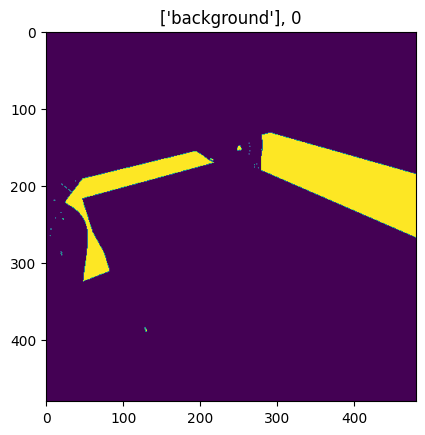

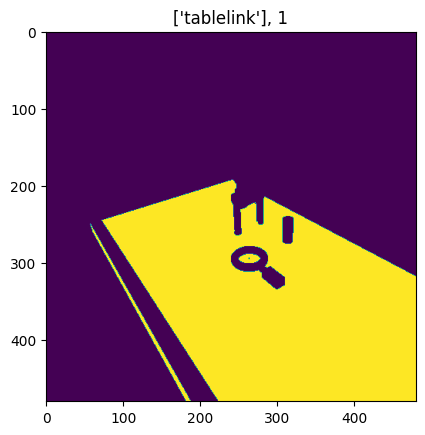

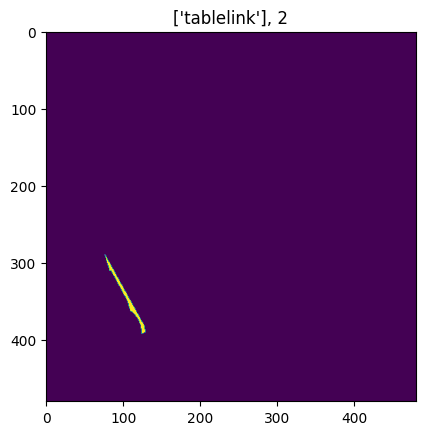

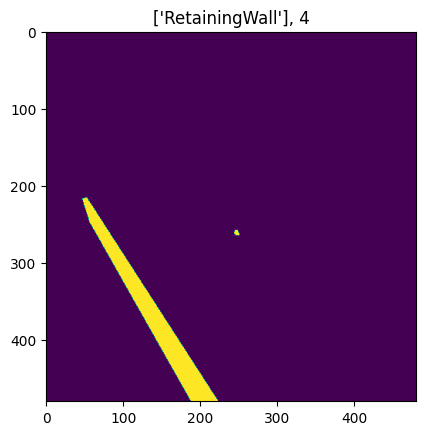

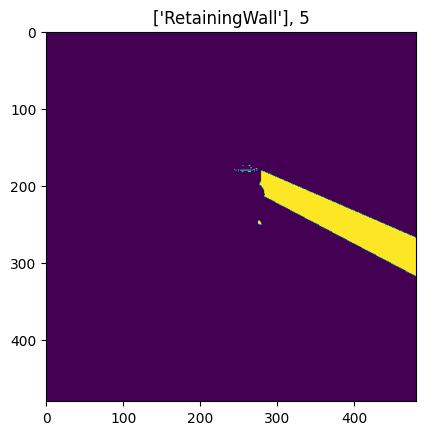

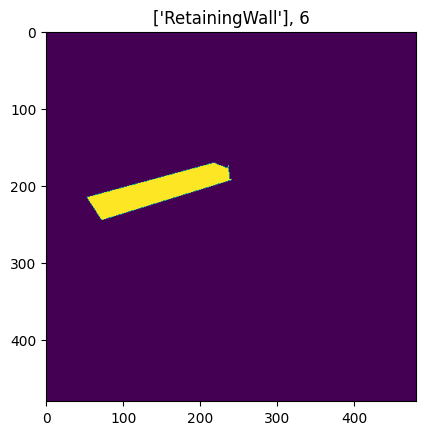

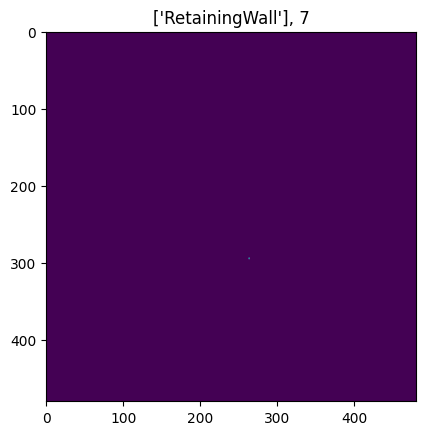

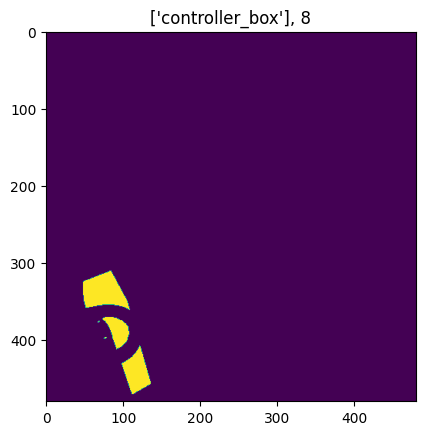

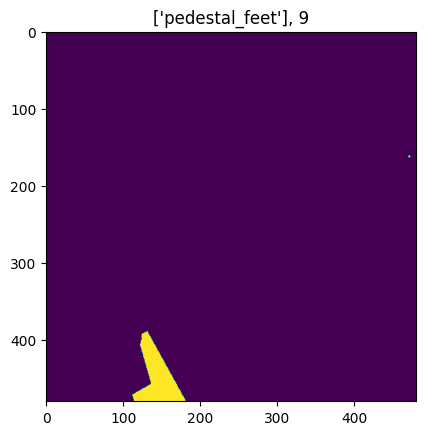

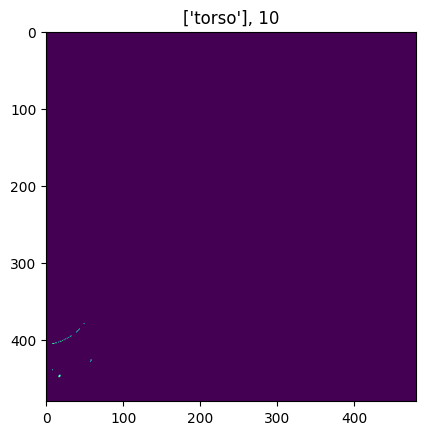

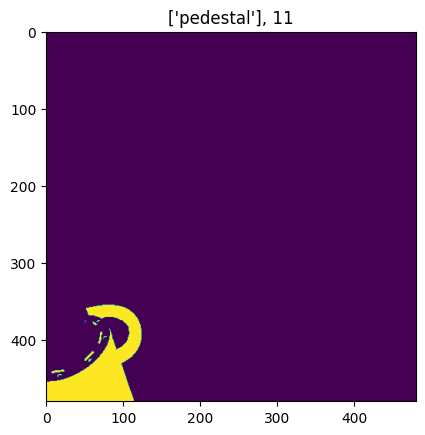

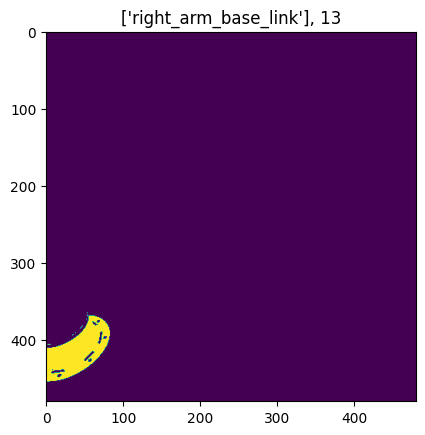

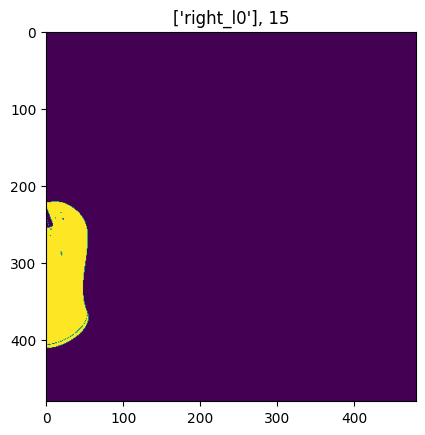

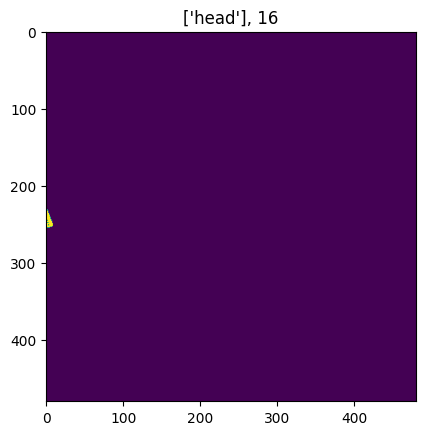

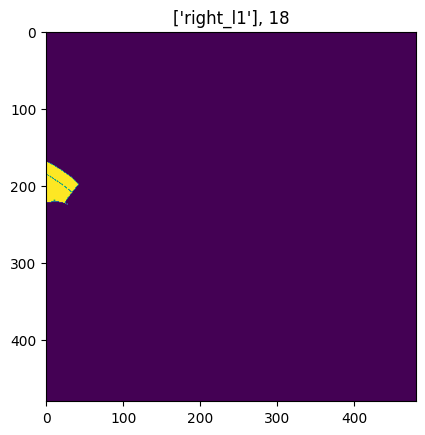

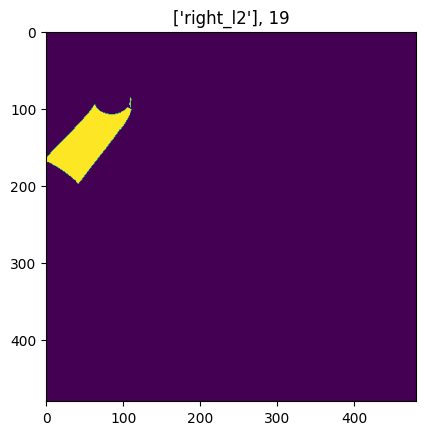

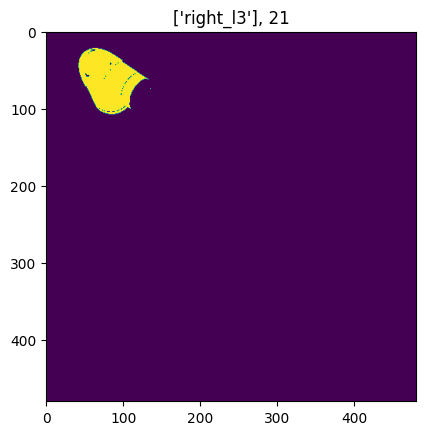

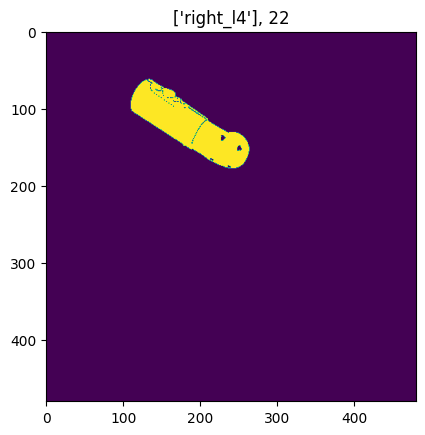

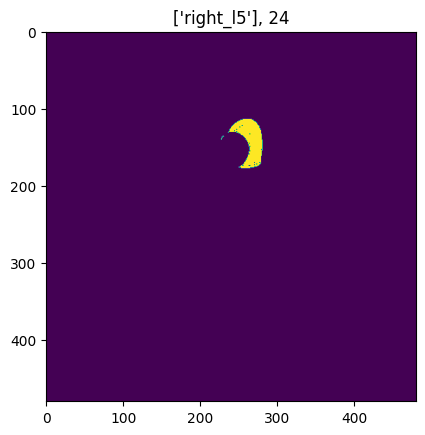

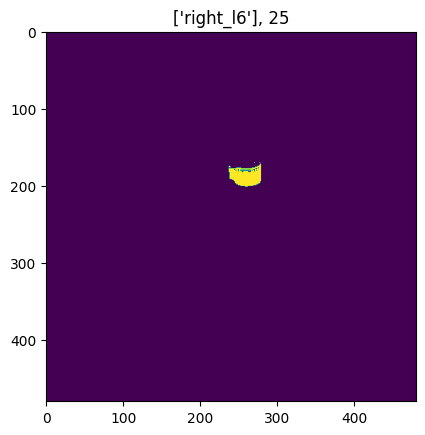

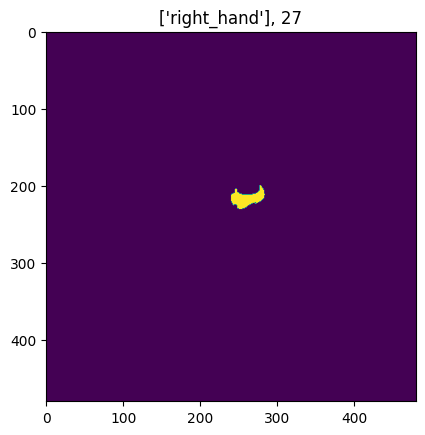

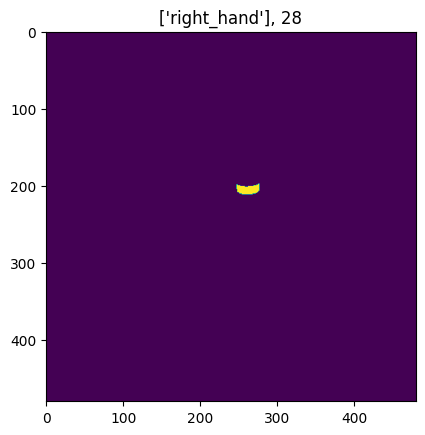

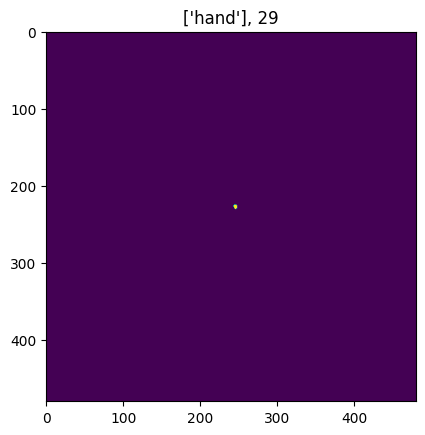

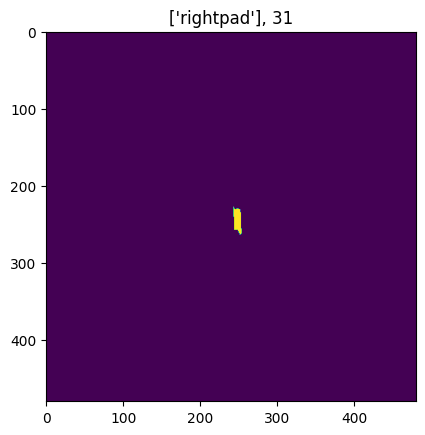

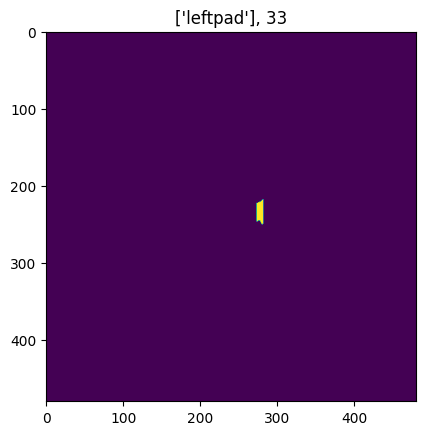

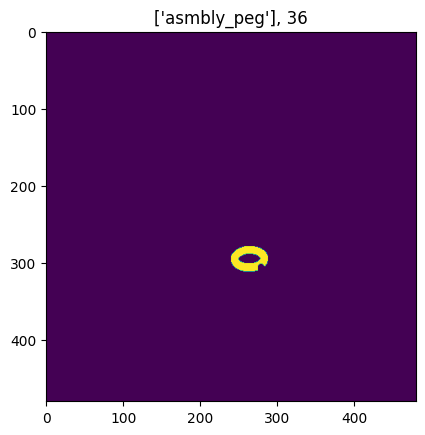

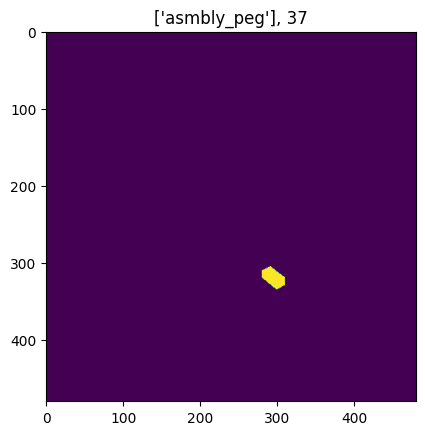

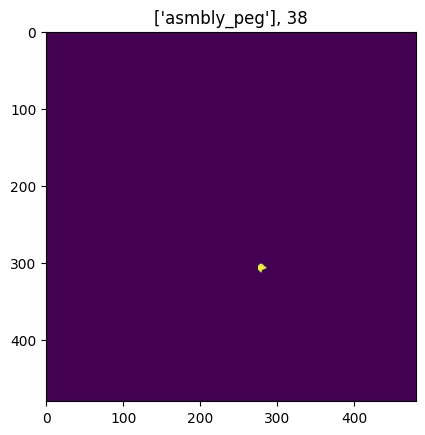

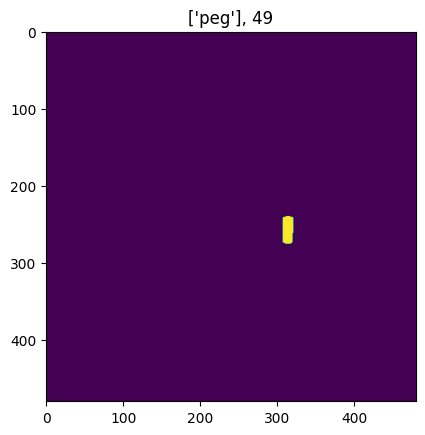

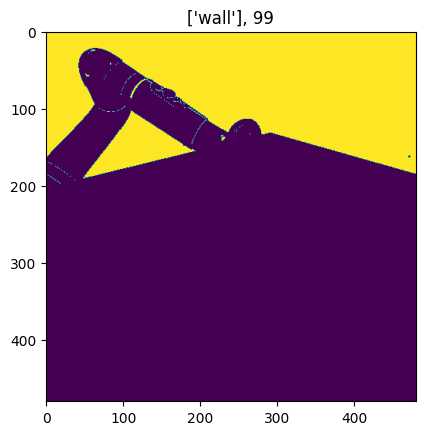

In [212]:
seg = episode[0]['original_mask']
ooi_mapping = episode[0]['original_ooi_mapping']
unique_values = np.unique(seg)
for i in unique_values: 
    if i < 0:
        continue
    plt.imshow(seg == i)
    plt.title(f"{ooi_mapping[i]}, {i}")
    plt.show()
